# Optimasi Portofolio dengan NSGA-II


In [1]:
%load_ext autoreload
%autoreload 2

## **A. Pengumpulan Dataset**
Dataset pada penelitian ini diperoleh melalui Yahoo Finance menggunakan library yfinance. Tujuannya adalah menyediakan data harga historis yang bersih dan konsisten untuk keperluan optimisasi portofolio.

### 1. Pemilihan Saham (LQ45)
Penelitian menggunakan 15 saham dari indeks LQ45 karena:
- Likuiditas tinggi
- Kapitalisasi besar
- Stabil untuk dianalisis
- Mewakili sektor yang beragam

Emiten yang digunakan antara lain: perbankan (BBCA, BBRI, BMRI, BBNI), telekomunikasi (TLKM), industri dasar, energi, consumer goods, dan lainnya.

### 2. Periode Penelitian
Rentang waktu yang digunakan adalah 1 November 2022 sampai 1 November 2025. Periode ini dipilih karena:
- memberikan cakupan historis yang cukup panjang untuk menangkap perubahan tren dan volatilitas,
- mencakup fase pemulihan ekonomi pascapandemi, fluktuasi komoditas, serta dinamika pasar global,
- bersifat fixed, sehingga hasil penelitian dapat direplikasi secara konsisten.

### 3. Sifat Data yang Diambil
Data yang digunakan adalah harga penutupan harian yang sudah disesuaikan (adjusted close). Data ini dianggap lebih representatif untuk analisis risiko-return karena telah memperhitungkan aksi korporasi seperti:

- stock split,
- dividen,
- maupun penyesuaian teknis lainnya.

Dengan cara ini, pola pergerakan harga yang dianalisis lebih stabil dan tidak bias terhadap perubahan struktural.

### 4. Pertimbangan Kualitas Data
Dalam pengumpulan dataset, beberapa hal juga diperhatikan:

- Likuiditas: saham yang terlalu sering tidak diperdagangkan berpotensi menghasilkan noise atau missing values.
- Kebersihan data: adanya hari libur atau suspensi perdagangan membuat beberapa data perlu dibersihkan agar time series tetap konsisten.
- Stabilitas return: dataset yang bersih membantu memastikan bahwa hasil optimisasi tidak bias akibat outlier teknis.

In [2]:
from src.dataset import download_data, process_data
import datetime

# 15 well-known ticker from LQ45
tickers = [
    "BBCA.JK",  # Bank Central Asia
    "BBRI.JK",  # Bank Rakyat Indonesia
    "BMRI.JK",  # Bank Mandiri
    "BBNI.JK",  # Bank Negara Indonesia
    "TLKM.JK",  # Telkom Indonesia
    "ASII.JK",  # Astra International
    "BYAN.JK",  # Bayan Resources
    "TPIA.JK",  # Chandra Asri
    "AMRT.JK",  # Sumber Alfaria Trijaya
    "GOTO.JK",  # GoTo Gojek Tokopedia
    "MDKA.JK",  # Merdeka Copper Gold
    "ADRO.JK",  # Adaro Energy
    "ICBP.JK",  # Indofood CBP
    "UNVR.JK",  # Unilever Indonesia
    "KLBF.JK",  # Kalbe Farma
]

# Take 3years ago to today
start_date = datetime.date(2022, 11, 1)
end_date = datetime.date(2025, 11, 1)

# Dataset
df = download_data(tickers, start_date, end_date)
r_matrix, mu_vector = process_data(df)

========== Downloading Data ==========


[*********************100%***********************]  15 of 15 completed

Successfully downloaded and cleaned data!
========== End ==========
========== Processing Data ==========
----- Vector expected return (mu) preview: -----
Ticker
ADRO.JK    0.000683
AMRT.JK   -0.000138
ASII.JK    0.000451
BBCA.JK    0.000184
BBNI.JK    0.000328
----- Matrix return history preview: -----
Ticker       ADRO.JK   AMRT.JK   ASII.JK   BBCA.JK   BBNI.JK   BBRI.JK  \
Date                                                                     
2022-11-02 -0.002667 -0.039855 -0.022814 -0.005682 -0.015957 -0.010730   
2022-11-03  0.002674 -0.007547 -0.007782  0.005714  0.005405  0.008677   

Ticker       BMRI.JK   BYAN.JK   GOTO.JK   ICBP.JK   KLBF.JK   MDKA.JK  \
Date                                                                     
2022-11-02 -0.031250 -0.005137  0.059783  0.010526 -0.007557  0.037433   
2022-11-03  0.009926  0.003787  0.025641 -0.005208  0.000000 -0.020619   

Ticker       TLKM.JK   TPIA.JK   UNVR.JK  
Date                                      
2022-11-02 -0.0

## **B. Optimasi dengan NSGA-II**
### 1. Formulasi Masalah (Multi-Objektif)

Setelah data historis diolah, masalah optimisasi portofolio didefinisikan sebagai Multi-Objective Problem (MOP). Tujuan utama adalah mencari trade-off terbaik di antara dua objektif yang saling bertentangan:

- Objektif $f_1$ (Return): Maksimasi Expected Return Portofolio (Mean).

Ini merepresentasikan potensi keuntungan investasi. - Objektif $f_2$ (Risiko): Minimasi Conditional Value at Risk (CVaR).
Kami fokus pada CVaR karena efektivitasnya dalam menangkap kerugian ekstrem (tail risk), yang merupakan risiko paling relevan bagi investor di dunia nyata.

Batasan Utama (Constraints):
Solusi bobot portofolio ($\mathbf{w}$) harus mematuhi:
- Bobot total harus 100% ($\sum w_i = 1$).
- Tidak ada short selling ($w_i \ge 0$).
- Bobot maksimum per aset dibatasi 30% ($w_i \le 0.3$) untuk menjamin diversifikasi.

### 2. Penentuan Parameter dan Algoritma

Digunakan NSGA-II karena efisien dan terbukti robust untuk masalah optimisasi 2-objektif. Parameter yang digunakan dipilih berdasarkan baseline yang teruji di literatur, sesuai dengan batasan penelitian (tidak melakukan tuning parameter mendalam).

Parameter NSGA-II: (1) Ukuran Populasi: 100, (2) Jumlah Generasi: 200.
Operator Evolusi: Menggunakan Simulated Binary Crossover (SBX) dan Polynomial Mutation (PM), standar untuk Algoritma Genetika real-coded.

In [6]:
n_stocks = 15  # N=15 saham
w_max = 0.3  # Batasan holding maksimum 30% per saham
n_population = 100  # Ukuran populasi
n_generations = 200  # Jumlah generasi

In [7]:
from src.optimizer import run_optimization

result = run_optimization(
    r_matrix, mu_vector, n_population, n_generations, n_stocks, w_max
)

if result is not None:
    pf_f, pf_w = result
    print("Optimization returned valid results. Variables unpacked successfully.")
else:
    # Handle the failure case appropriately
    print("Error: Optimization failed to find a solution.")
    pf_f, pf_w = None, None

----- Optimisasi dengan NSGA-II (Default) -----
   Populasi: 100
   Generasi: 200
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      4 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     10 |  0.000000E+00 |  0.000000E+00 |  0.3981791017 |         ideal
     3 |      300 |     13 |  0.000000E+00 |  0.000000E+00 |  0.1428518793 |         ideal
     4 |      400 |     14 |  0.000000E+00 |  0.000000E+00 |  0.2169300627 |         ideal
     5 |      500 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0466475414 |         ideal
     6 |      600 |     16 |  0.000000E+00 |  0.000000E+00 |  0.1104344978 |         ideal
     7 |      700 |     13 |  0.000000E+00 |  0.000000E+00 |  0.1969835218 |         ideal
     8 |      800 |     14 |  0.000000E+00 |  0.000000E+00 |  0.1236689475 |         ideal
     9 |      900 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0303293268 |         ideal
    10 |

## **C. Visualisasi dan Analisis Hasil**

Memulai visualisasi dan analisis...

Visualisasi Pareto Front berhasil dibuat.
Plot disimpan di 'result/pareto_front_plot.png'


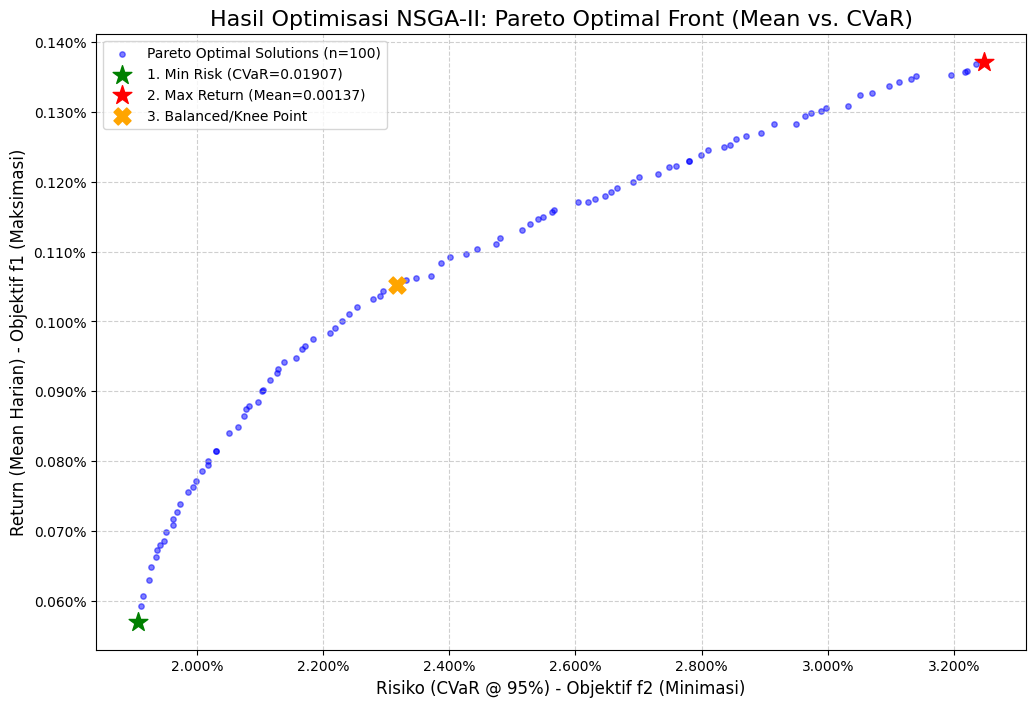


1. Portofolio Risiko Minimum (Paling Konservatif)
  > Mean Return (f1): 0.000570 (Daily)
  > CVaR Risk (f2)  : 0.019074 (Daily @ 95%)

  Komposisi Bobot (di atas 0.5%):
    - BYAN.JK : 21.54%
    - BBCA.JK : 20.60%
    - ASII.JK : 19.24%
    - ICBP.JK : 18.06%
    - BBNI.JK :  5.91%
    - KLBF.JK :  4.26%
    - ADRO.JK :  3.45%
    - MDKA.JK :  3.09%
    - TLKM.JK :  1.33%
    - TPIA.JK :  1.31%
    - UNVR.JK :  0.53%

3. Portofolio Titik Tengah (Balanced/Knee)
  > Mean Return (f1): 0.001053 (Daily)
  > CVaR Risk (f2)  : 0.023166 (Daily @ 95%)

  Komposisi Bobot (di atas 0.5%):
    - BYAN.JK : 29.78%
    - ASII.JK : 25.53%
    - TPIA.JK : 16.17%
    - ICBP.JK : 12.03%
    - BBNI.JK : 11.81%
    - ADRO.JK :  2.56%
    - BBCA.JK :  1.15%

2. Portofolio Return Maksimum (Paling Agresif)
  > Mean Return (f1): 0.001372 (Daily)
  > CVaR Risk (f2)  : 0.032471 (Daily @ 95%)

  Komposisi Bobot (di atas 0.5%):
    - TPIA.JK : 29.97%
    - BYAN.JK : 29.92%
    - ASII.JK : 20.79%
    - ADRO.JK : 1

In [ ]:
from src.visualize import visualize_results

if pf_f is not None and pf_w is not None:
    tickers_list = mu_vector.index.to_list()
    visualize_results(pareto_front_F=pf_f, pareto_weights_X=pf_w, tickers=tickers_list)


### 1. Analisis Kurva Optimal
Output utama dari `optimizer.py` adalah Pareto Optimal Front, yang berisi 100 portofolio non-dominan (optimal). Kurva ini merepresentasikan "menu" trade-off yang tersedia bagi investor.

Visualisasi di bawah (Gambar 1) memetakan 100 portofolio ini dalam grafik 2D:
- Sumbu-Y (Vertikal): Return (Mean Harian). Semakin tinggi, semakin baik (Maksimasi).
- Sumbu-X (Horizontal): Risiko (CVaR @ 95%). Semakin ke kiri, semakin baik (Minimasi).

Temuan Utama dari Plot:
Plot ini secara visual membuktikan trade-off yang ada. Untuk mendapatkan return harian yang lebih tinggi (bergerak ke atas dari 0.057% ke 0.136%), investor harus menerima risiko kerugian ekstrem (CVaR) yang lebih tinggi (bergerak ke kanan dari 1.907% ke 3.101%).

### 2. Interpretasi Komposisi Aset

Analisis selanjutnya berfokus pada bagaimana komposisi bobot ($\mathbf{w}$) berubah di antara ketiga portofolio kunci tersebut. Hasil ini memberikan wawasan praktis bagi investor dalam menyusun strategi alokasi aset sesuai dengan profil risiko mereka (konservatif, moderat, atau agresif).

Portofolio:
1. Min Risk
   - Return: 0.057% (Rendah)
   - Risk: 1.907% (Terendah)
   - Top 5 Holdings:
     1. BYAN.JK: 22.87% 
     2. BBCA.JK: 20.63% 
     3. ICBP.JK: 19.37% 
     4. ASII.JK: 17.33% 
     5. KLBF.JK: 4.44%
2. Balanced
   - Return: 0.105% (Tengah)
   - Risk: 2.286% (Rendah-Tengah)
   - Top 5 Holdings:
      1. BYAN.JK: 29.74% 
      2. ASII.JK: 27.57% 
      3. TPIA.JK: 14.89% 
      4. ICBP.JK: 9.15% 
      5. BBCA.JK: 7.75%
3. Max Return
   - Return: 0.136% (Tertinggi)
   - Risk: 3.101% (Tinggi)
   - Top 5 Holdings:
     1. BYAN.JK: 29.96% 
     2. TPIA.JK: 29.66% 
     3. ASII.JK: 25.81% 
     4. BBCA.JK: 6.46% 
     5. ADRO.JK: 5.04%

## Perbandingan NSGA II dengan NSGA III

>>> MEMULAI EKSPERIMEN HEAD-TO-HEAD <<<

----- Optimisasi dengan NSGA-II (Default) -----
   Populasi: 100
   Generasi: 200
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      4 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     10 |  0.000000E+00 |  0.000000E+00 |  0.3981791017 |         ideal
     3 |      300 |     13 |  0.000000E+00 |  0.000000E+00 |  0.1428518793 |         ideal
     4 |      400 |     14 |  0.000000E+00 |  0.000000E+00 |  0.2169300627 |         ideal
     5 |      500 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0466475414 |         ideal
     6 |      600 |     16 |  0.000000E+00 |  0.000000E+00 |  0.1104344978 |         ideal
     7 |      700 |     13 |  0.000000E+00 |  0.000000E+00 |  0.1969835218 |         ideal
     8 |      800 |     14 |  0.000000E+00 |  0.000000E+00 |  0.1236689475 |         ideal
     9 |      900 |     14 |  0.000000E+00 |  0.000000E+00

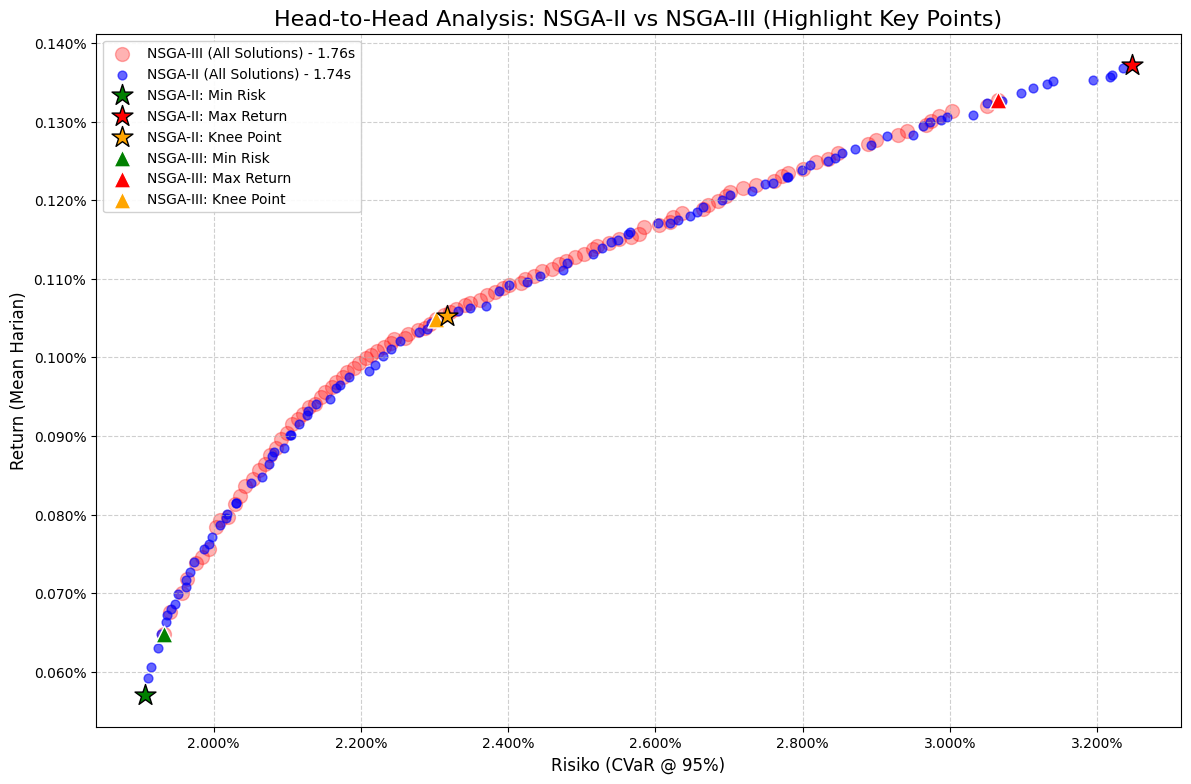

ANALISIS KOMPOSISI PORTOFOLIO: NSGA-II vs NSGA-III

>>> BATTLE: KNEE POINT (BALANCED) <<<
NSGA-II  : Return 0.001053 | CVaR 0.023166
NSGA-III : Return 0.001048 | CVaR 0.023026
----------------------------------------
Komposisi NSGA-II (Knee):

  --- NSGA-II ---
    BYAN.JK : 29.78%
    ASII.JK : 25.53%
    TPIA.JK : 16.17%
    ICBP.JK : 12.03%
    BBNI.JK : 11.81%
    ADRO.JK :  2.56%
    BBCA.JK :  1.15%

Komposisi NSGA-III (Knee):

  --- NSGA-III ---
    BYAN.JK : 29.82%
    ASII.JK : 27.42%
    TPIA.JK : 15.41%
    ICBP.JK : 12.52%
    BBNI.JK : 10.48%
    ADRO.JK :  3.92%

>>> BATTLE: MINIMUM RISK <<<
NSGA-II  : CVaR 0.019074
NSGA-III : CVaR 0.019323

  --- NSGA-II (Min Risk) ---
    BYAN.JK : 21.54%
    BBCA.JK : 20.60%
    ASII.JK : 19.24%
    ICBP.JK : 18.06%
    BBNI.JK :  5.91%
    KLBF.JK :  4.26%
    ADRO.JK :  3.45%
    MDKA.JK :  3.09%
    TLKM.JK :  1.33%
    TPIA.JK :  1.31%
    UNVR.JK :  0.53%

  --- NSGA-III (Min Risk) ---
    BYAN.JK : 23.95%
    BBCA.JK : 21.44%
   

In [10]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import time


# --- Helper Function untuk Analisis Titik Kunci ---
def get_key_points(pf, weights):
    """Mencari index untuk Min Risk, Max Return, dan Knee Point"""
    mean_ret = pf[:, 0]
    cvar = pf[:, 1]

    # 1. Min Risk
    idx_min = np.argmin(cvar)

    # 2. Max Return
    idx_max = np.argmax(mean_ret)

    # 3. Knee Point (Euclidean Distance to Utopia)
    # Normalize dulu biar adil
    norm_ret = (mean_ret - mean_ret[idx_min]) / (mean_ret[idx_max] - mean_ret[idx_min])
    norm_cvar = (cvar - cvar[idx_min]) / (cvar[idx_max] - cvar[idx_min])
    # Target: Risk=0 (setelah norm), Return=1 (setelah norm)
    dists = np.sqrt((norm_ret - 1) ** 2 + (norm_cvar - 0) ** 2)
    idx_knee = np.argmin(dists)

    return idx_min, idx_knee, idx_max


def print_composition(title, weights, tickers):
    print(f"\n  --- {title} ---")
    # Sort & Filter > 0.5%
    items = sorted(
        [(tickers[i], weights[i]) for i in range(len(tickers))],
        key=lambda x: x[1],
        reverse=True,
    )
    for t, w in items:
        if w > 0.005:
            print(f"    {t:<8}: {w:>6.2%}")


# --- 1. Setup & Run ---
print(">>> MEMULAI EKSPERIMEN HEAD-TO-HEAD <<<\n")
tickers_list = mu_vector.index.to_list()

# NSGA-III Setup
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=99)
nsga3_algo = NSGA3(ref_dirs=ref_dirs, pop_size=n_population)

# Run NSGA-II
t0 = time.time()
res_n2 = run_optimization(
    r_matrix, mu_vector, n_population, n_generations, n_stocks, w_max, algorithm=None
)
dt_n2 = time.time() - t0

# Run NSGA-III
t0 = time.time()
res_n3 = run_optimization(
    r_matrix,
    mu_vector,
    n_population,
    n_generations,
    n_stocks,
    w_max,
    algorithm=nsga3_algo,
)
dt_n3 = time.time() - t0

# --- 2. Visualisasi & Analisis ---
if res_n2 and res_n3:
    pf2, w2 = res_n2
    pf3, w3 = res_n3

    # Cari Titik Kunci
    k2_min, k2_knee, k2_max = get_key_points(pf2, w2)
    k3_min, k3_knee, k3_max = get_key_points(pf3, w3)

    plt.figure(figsize=(14, 9))

    # Plot Scatter Dasar (Transparan)
    plt.scatter(
        pf3[:, 1],
        pf3[:, 0],
        c="red",
        s=100,
        alpha=0.3,
        label=f"NSGA-III (All Solutions) - {dt_n3:.2f}s",
    )
    plt.scatter(
        pf2[:, 1],
        pf2[:, 0],
        c="blue",
        s=40,
        alpha=0.6,
        label=f"NSGA-II (All Solutions) - {dt_n2:.2f}s",
    )

    # --- Highlight Titik Kunci NSGA-II (Bintang) ---
    plt.scatter(
        pf2[k2_min, 1],
        pf2[k2_min, 0],
        c="green",
        marker="*",
        s=250,
        edgecolors="black",
        zorder=10,
        label="NSGA-II: Min Risk",
    )
    plt.scatter(
        pf2[k2_max, 1],
        pf2[k2_max, 0],
        c="red",
        marker="*",
        s=250,
        edgecolors="black",
        zorder=10,
        label="NSGA-II: Max Return",
    )
    plt.scatter(
        pf2[k2_knee, 1],
        pf2[k2_knee, 0],
        c="orange",
        marker="*",
        s=250,
        edgecolors="black",
        zorder=10,
        label="NSGA-II: Knee Point",
    )

    # --- Highlight Titik Kunci NSGA-III (Segitiga) ---
    # Kita geser dikit posisinya (offset) biar gak ketutupan total kalau nilainya sama persis
    # Tapi kalau mau jujur apa adanya, hapus offset-nya.
    plt.scatter(
        pf3[k3_min, 1],
        pf3[k3_min, 0],
        c="green",
        marker="^",
        s=150,
        edgecolors="white",
        zorder=9,
        label="NSGA-III: Min Risk",
    )
    plt.scatter(
        pf3[k3_max, 1],
        pf3[k3_max, 0],
        c="red",
        marker="^",
        s=150,
        edgecolors="white",
        zorder=9,
        label="NSGA-III: Max Return",
    )
    plt.scatter(
        pf3[k3_knee, 1],
        pf3[k3_knee, 0],
        c="orange",
        marker="^",
        s=150,
        edgecolors="white",
        zorder=9,
        label="NSGA-III: Knee Point",
    )

    plt.title(
        "Head-to-Head Analysis: NSGA-II vs NSGA-III (Highlight Key Points)", fontsize=16
    )
    plt.xlabel("Risiko (CVaR @ 95%)", fontsize=12)
    plt.ylabel("Return (Mean Harian)", fontsize=12)
    plt.legend(loc="upper left", fontsize=10, framealpha=0.9)
    plt.grid(True, linestyle="--", alpha=0.6)

    ax = plt.gca()
    formatter = FuncFormatter(lambda y, _: f"{y:.3%}")
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)

    plt.show()

    # --- Laporan Komposisi ---
    print("=" * 80)
    print("ANALISIS KOMPOSISI PORTOFOLIO: NSGA-II vs NSGA-III")
    print("=" * 80)

    # Knee Point Battle
    print("\n>>> BATTLE: KNEE POINT (BALANCED) <<<")
    print(f"NSGA-II  : Return {pf2[k2_knee, 0]:.6f} | CVaR {pf2[k2_knee, 1]:.6f}")
    print(f"NSGA-III : Return {pf3[k3_knee, 0]:.6f} | CVaR {pf3[k3_knee, 1]:.6f}")
    print("-" * 40)
    print("Komposisi NSGA-II (Knee):")
    print_composition("NSGA-II", w2[k2_knee], tickers_list)
    print("\nKomposisi NSGA-III (Knee):")
    print_composition("NSGA-III", w3[k3_knee], tickers_list)

    # Min Risk Battle
    print("\n" + "=" * 40)
    print(">>> BATTLE: MINIMUM RISK <<<")
    print(f"NSGA-II  : CVaR {pf2[k2_min, 1]:.6f}")
    print(f"NSGA-III : CVaR {pf3[k3_min, 1]:.6f}")
    print_composition("NSGA-II (Min Risk)", w2[k2_min], tickers_list)
    print_composition("NSGA-III (Min Risk)", w3[k3_min], tickers_list)

else:
    print("Gagal menjalankan salah satu algoritma.")